# 결론 

- sentence piece가 조금더 성능이 좋다

# 멋진 단어사전 만들기 [프로젝트]

- 네이버 영화리뷰 감정 분석 태스크
- 모델은 다 같은 LSTM 8차원짜리 1층을 사용하고 dense층을 사용한 분류기(0,1)

- 첫번째 실험 
    - 전처리 전혀 X
        - 불필요한 단어 제거X
        - 문장길이 모두다 수용
    - tokenize 방법 : SentencePiece
    
    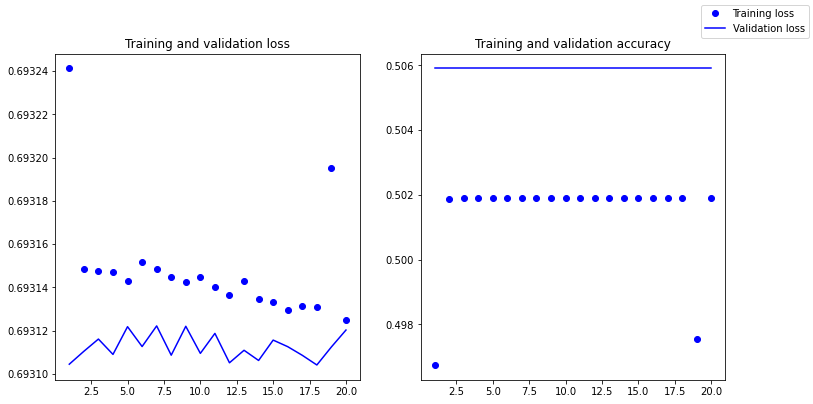
    

- 두번째 실험 
    - 전처리 전혀 X
    - tokenize 방법 : KoNLPy 형태소 분석기 - mecab
    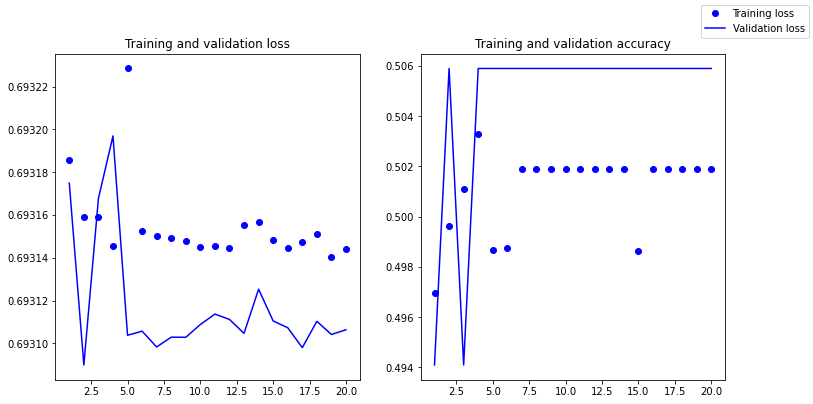
    
    
## 둘다 점수를 비교하기 힘들정도로 개판이다.
- 전처리를 진행하고 해보자!
  
   
- 세번째 실험 - mecab : **val_loss: 0.8050 - val_accuracy: 0.7777**
    - 전처리_v1
        - 한글 영어 빼고 다 삭제
        - min 10 - max 50으로 문장 길이 조절
    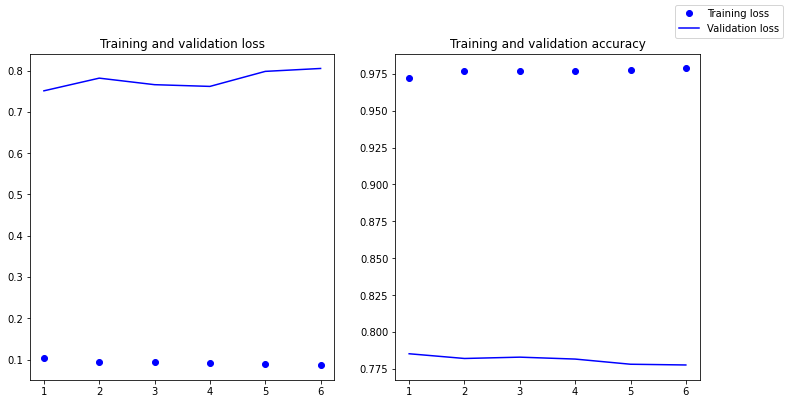

- 네번째 실험 - sentence piece : **val_loss: 0.5773 - val_accuracy: 0.8009**
    - 전처리_v1
    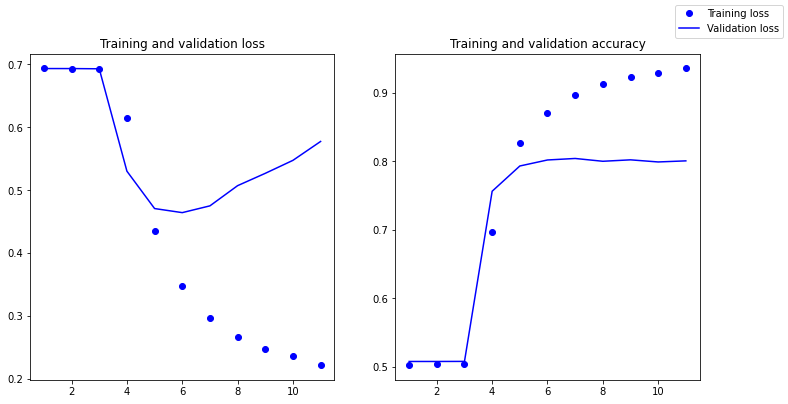
    

# 같은 조건에서 실험했을때는 점수가 sentence piece 점주가 조금더 높았다
    

In [1]:
!pip install sentencepiece

In [25]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# 원래 사용되는 토크나이즈 함수

In [2]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

# 자연어 데이터를 가져와서 전처리를 해보자

In [4]:
import os
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [52]:
raw[0]

'개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"'

문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 60


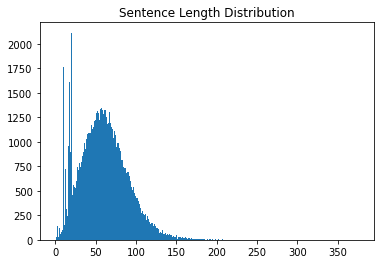

In [26]:
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [22]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(raw, 1)

’


In [27]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 11
Outlier Index: 19
Outlier Index: 21


In [31]:
# check_sentence_with_length(raw, 21)

Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


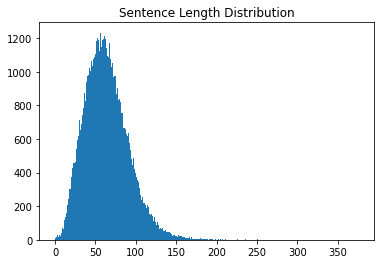

In [32]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

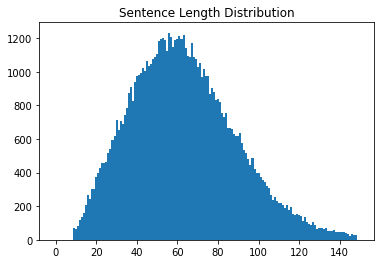

In [33]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [21]:
raw[0:1][::20]

['개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"']

In [34]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 376816 Oct 10 06:08 korean_spm.model
-rw-r--r-- 1 root root 146213 Oct 10 06:08 korean_spm.vocab


In [35]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1243, 11, 302, 7, 3608, 11, 287, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [36]:
def sp_tokenize(s, corpus): 

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

# 네이버 데이터셋 가져오기

In [40]:
import pandas as pd

# 데이터를 읽어봅시다. 

traindata_path = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/ratings_train.txt'
testdata_path = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/ratings_test.txt'

train_data = pd.read_table(traindata_path)
test_data = pd.read_table(testdata_path)

train_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [55]:
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data = train_data.dropna(how = 'any') 
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data = test_data.dropna(how = 'any') 

In [82]:
raw_cop = list(train_data['document'])
train_label = train_data['label']

# 문장길이를 봐보자
- 보려고 하니 오류가 난다 -> nan값이 있어서 그런듯하다 (결측치 제거해주자)
- 생각보다는 고루 분포하나? 싶은 느낌

In [65]:
len(raw_cop)

49157

문장의 최단 길이: 1
문장의 최장 길이: 144
문장의 평균 길이: 18


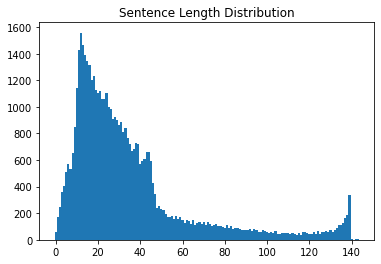

In [60]:
min_len = 999
max_len = 0
sum_len = 0

for sen in raw_cop:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=int)

for sen in raw_cop:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

# 짧은 문장들 확인

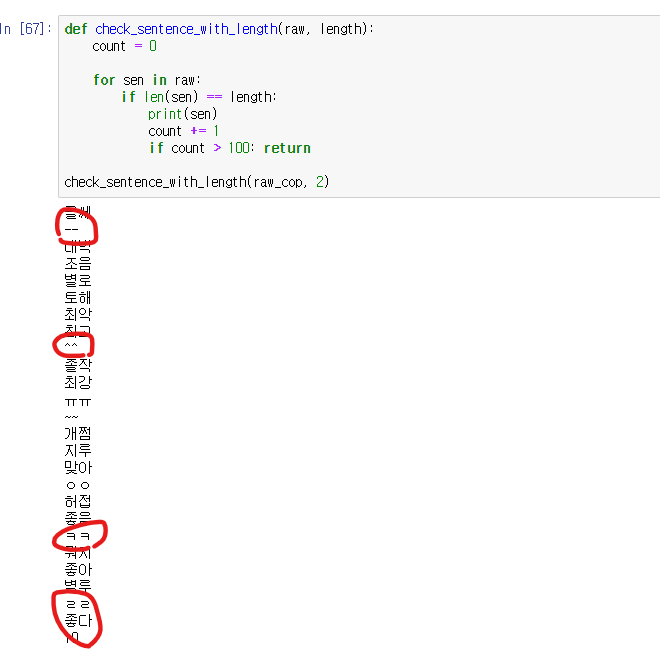

- 전처리를 해야될 필요성을 느낀다..
- 문장길이도 적당히 잘라줘도 좋을것같다

In [68]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

# check_sentence_with_length(raw_cop, 2)

In [70]:
# 전처리도 따로따로 진행해보자

def preprocess_sentence(sentence):
    # 온점 사이에 공백을 넣기
#     sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 연속 공백을 하나의 공백으로 변환
#     sentence = re.sub(r'[" "]+', " ", sentence)
    # 큰따옴표를 제거
#     sentence = re.sub(r'["]', '', sentence)
    # 완성되지 않은 표현을 제거 (ㅜㅜ 또는 ㅇㅇ 같은 느낌)
#     sentence = re.sub(r"[ㄱ-ㅎㅏ-ㅣ]+", "", sentence)
    # 양쪽 공백을 제거
    sentence = sentence.strip()
    return sentence

In [74]:
# 첫번째 조건은 일단 전부 넣어보자

max_len = 145
min_len = 0

# cleaned_corpus = preprocess_sentence(raw_cop)

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [preprocess_sentence(s) for s in raw_cop if (len(s) < max_len) & (len(s) >= min_len)]

In [93]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 375874 Oct 10 07:54 korean_spm.model
-rw-r--r-- 1 root root 145359 Oct 10 07:54 korean_spm.vocab


In [94]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')



True

In [95]:
tensor, word_index, index_word = sp_tokenize(s,filtered_corpus)

In [96]:
tensor.shape

(49157, 116)

In [97]:
# validation set 20000건 분리
X_val = tensor[:10000]   
y_val = train_label[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = tensor[10000:]
partial_y_train = train_label[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(39157, 116)
(39157,)


In [98]:
vocab_size = len(word_index) # 어휘 사전의 크기입니다 - word_to_index의 길이 load_data 보면 설정해줬음 10000개로
word_vector_dim = 512   # 학습시키면서 진행할테니 - 일단 16차원으로 적어둔다

model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

In [99]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
77/77 [==============================] - 3s 16ms/step - loss: 0.6932 - accuracy: 0.4967 - val_loss: 0.6931 - val_accuracy: 0.5059
Epoch 2/20
77/77 [==============================] - 1s 10ms/step - loss: 0.6931 - accuracy: 0.5019 - val_loss: 0.6931 - val_accuracy: 0.5059
Epoch 3/20
77/77 [==============================] - 1s 9ms/step - loss: 0.6931 - accuracy: 0.5019 - val_loss: 0.6931 - val_accuracy: 0.5059
Epoch 4/20
77/77 [==============================] - 1s 9ms/step - loss: 0.6931 - accuracy: 0.5019 - val_loss: 0.6931 - val_accuracy: 0.5059
Epoch 5/20
77/77 [==============================] - 1s 10ms/step - loss: 0.6931 - accuracy: 0.5019 - val_loss: 0.6931 - val_accuracy: 0.5059
Epoch 6/20
77/77 [==============================] - 1s 9ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6931 - val_accuracy: 0.5059
Epoch 7/20
77/77 [==============================] - 1s 10ms/step - loss: 0.6931 - accuracy: 0.5019 - val_loss: 0.6931 - val_accuracy: 0.5059
Epoch 8/20
77/77

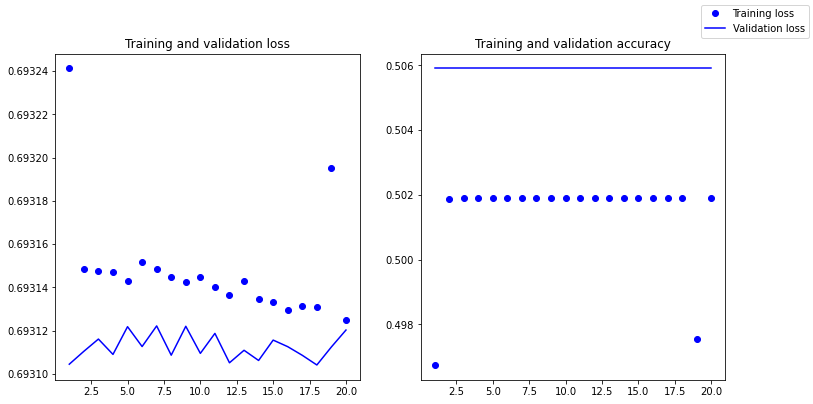

In [101]:

history_dict3 = history3.history


import matplotlib.pyplot as plt


acc3 = history_dict3['accuracy']

val_acc3 = history_dict3['val_accuracy']


loss3 = history_dict3['loss']


val_loss3 = history_dict3['val_loss']

epochs = range(1, len(acc3) + 1)

fig, axs = plt.subplots(1,2, figsize = (12,6))

axs[0].plot(epochs, loss3, 'bo', label='Training loss')
axs[0].plot(epochs, val_loss3, 'b', label='Validation loss')
axs[0].set_title('Training and validation loss')

axs[1].plot(epochs, acc3, 'bo')
axs[1].plot(epochs, val_acc3, 'b')
axs[1].set_title('Training and validation accuracy')



fig.legend()